TensorFlow version: 2.6.4
JAX version: 0.3.13
Interactive? True
368


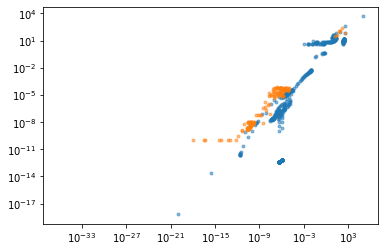

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import tensorflow as tf
import jax
import keras
from sklearn import metrics
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, BatchNormalization
from tensorflow.keras import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 0だけを使用するように設定
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # 必要に応じてメモリ成長を許可
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # プログラムの実行時にデバイスが設定されているとエラーが発生するので注意
        print(e)

# Environment Configuration
os.environ["KERAS_BACKEND"] = "jax"

def setup_environment():
    print(f"TensorFlow version: {tf.__version__}")
    print(f"JAX version: {jax.__version__}")

    def is_interactive():
        return 'runtime' in get_ipython().config.IPKernelApp.connection_file

    print('Interactive?', is_interactive())

    SEED = 42
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    return is_interactive

is_interactive = setup_environment()

# Paths and Data Loading
DATA = "../data"
DATA_TFREC = "../data"

def load_data(sample_path, tfrec_path):
    sample = pl.read_csv(sample_path, n_rows=1)
    TARGETS = sample.select(pl.exclude('sample_id')).columns
    print(len(TARGETS))

    def _parse_function(example_proto):
        feature_description = {
            'x': tf.io.FixedLenFeature([556], tf.float32),
            'targets': tf.io.FixedLenFeature([368], tf.float32)
        }
        e = tf.io.parse_single_example(example_proto, feature_description)
        return e['x'], e['targets']

    train_files = [os.path.join(tfrec_path, "train_%.3d.tfrec" % i) for i in range(100)]
    valid_files = [os.path.join(tfrec_path, "train_%.3d.tfrec" % i) for i in range(100, 101)]

    return TARGETS, train_files, valid_files, _parse_function

TARGETS, train_files, valid_files, _parse_function = load_data(
    os.path.join(DATA, "sample_submission.csv"),
    DATA_TFREC
)

# Data Pipeline
BATCH_SIZE = 2048
train_options = tf.data.Options()
train_options.experimental_deterministic = True

def create_dataset(files, batch_size, parse_function, train=True):
    ds = (
        tf.data.Dataset.from_tensor_slices(files)
        .with_options(train_options)
        .shuffle(100)
        .interleave(
            lambda file: tf.data.TFRecordDataset(file).map(parse_function, num_parallel_calls=tf.data.AUTOTUNE),
            num_parallel_calls=tf.data.AUTOTUNE,
            cycle_length=10,
            block_length=1000,
            deterministic=True
        )
        .shuffle(4 * batch_size if train else 1)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return ds

ds_train = create_dataset(train_files, BATCH_SIZE, _parse_function, train=True)
ds_valid = create_dataset(valid_files, BATCH_SIZE, _parse_function, train=False)

# Normalization
def normalize_data(ds_train, ds_valid):
    norm_x = keras.layers.Normalization()
    norm_x.adapt(ds_train.map(lambda x, y: x).take(20 if is_interactive else 1000))

    plt.scatter(
        norm_x.mean.numpy().squeeze(),
        np.sqrt(norm_x.variance.numpy().squeeze()),
        marker=".",
        alpha=0.5
    )
    plt.xscale('log')
    plt.yscale('log')

    norm_y = keras.layers.Normalization()
    norm_y.adapt(ds_train.map(lambda x, y: y).take(20 if is_interactive else 1000))

    mean_y = norm_y.mean.numpy()
    stdd_y = np.maximum(1e-10, np.sqrt(norm_y.variance.numpy()))

    plt.scatter(
        mean_y.squeeze(),
        stdd_y.squeeze(),
        marker=".",
        alpha=0.5
    )
    plt.xscale('log')
    plt.yscale('log')

    min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(20 if is_interactive else 1000)], 0), 0, keepdims=True)
    max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(20 if is_interactive else 1000)], 0), 0, keepdims=True)

    return norm_x, norm_y, mean_y, stdd_y

norm_x, norm_y, mean_y, stdd_y = normalize_data(ds_train, ds_valid)

# Model Definition
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.MeanSquaredError()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        r2_score = 1 - self.base_metric.result()
        return tf.reduce_mean(tf.clip_by_value(r2_score, 0.0, 1.0))

    def reset_states(self):
        self.base_metric.reset_states()
        
        



In [2]:
class PositionalEncoding(Layer):
    def __init__(self, d_model, dropout_rate, max_len=5000, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout = Dropout(dropout_rate)
        
        pos = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]

        angle_rads = self.get_angles(pos, i)
        
        # apply sin to even indices in the array; 2i
        angle_rads_sin = tf.math.sin(angle_rads[:, 0::2])
        
        # apply cos to odd indices in the array; 2i+1
        angle_rads_cos = tf.math.cos(angle_rads[:, 1::2])
        
        # concatenate sin and cos parts
        angle_rads = tf.concat([angle_rads_sin, angle_rads_cos], axis=-1)
        
        pos_encoding = angle_rads[tf.newaxis, ...]

        self.pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i):
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        return pos * angle_rates

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = x + self.pos_encoding[:, :seq_len, :]
        return self.dropout(x)
    
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, nhead, dim_feedforward, dropout_rate, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward
        self.dropout_rate = dropout_rate

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dim_feedforward, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        base_config = super(TransformerEncoderLayer, self).get_config()
        config = {
            'd_model': self.d_model,
            'nhead': self.nhead,
            'dim_feedforward': self.dim_feedforward,
            'dropout_rate': self.dropout_rate,
        }
        return dict(list(base_config.items()) + list(config.items()))

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, nhead, dim_feedforward, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward
        self.dropout_rate = dropout_rate
        
        self.batchnorm1 = keras.layers.BatchNormalization()
        self.batchnorm2 = keras.layers.BatchNormalization()
        self.input_linear = Dense(d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout_rate)
        self.enc_layers = [TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout_rate) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)
        self.conv1d = keras.layers.Conv1D(14, 1, padding='same')  # Move Conv1D definition here

    def call(self, x, training):
        x = self.input_linear(x)
        x = self.batchnorm1(x)
        
        x = self.pos_encoding(x)
        x = self.batchnorm2(x)
        x = self.dropout(x, training=training)

        for enc_layer in self.enc_layers:
            x = enc_layer(x, training=training)
            
        x = self.conv1d(x)  # Use self.conv1d here
        return x

    def get_config(self):
        base_config = super(TransformerEncoder, self).get_config()
        config = {
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'nhead': self.nhead,
            'dim_feedforward': self.dim_feedforward,
            'dropout_rate': self.dropout_rate,
        }
        return dict(list(base_config.items()) + list(config.items()))

def build_model(input_shape, norm_x, output_shape, d_model, nhead, num_encoder_layers, dim_feedforward, dropout_rate, learning_rate, steps_per_epoch, epochs):
         
    def x_to_seq(x):
        x_seq0 = tf.transpose(tf.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
        x_seq1 = tf.transpose(tf.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
        x_flat = tf.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
        x_flat = tf.tile(x_flat, [1, 60, 1])
        return tf.concat([x_seq0, x_seq1, x_flat], axis=-1)
    
    transformer_encoder = TransformerEncoder(
        num_encoder_layers,
        d_model,
        nhead,
        dim_feedforward,
        dropout_rate,
    )

    lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=(epochs - 1 - 2) * steps_per_epoch,
        alpha=0.1
    )
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Normalization(mean=norm_x.mean.numpy(), variance=norm_x.variance.numpy())(inputs)
    x = x_to_seq(x)
    p_all = transformer_encoder(x)

    p_seq = p_all[:, :, :6]
    p_seq = tf.transpose(p_seq, (0, 2, 1))
    p_seq = keras.layers.Flatten()(p_seq)

    p_flat = tf.reduce_mean(p_all[:, :, 6:6 + 8], axis=1)

    P = tf.concat([p_seq, p_flat], axis=1)
    
    model = Model(inputs, P)
    

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
        metrics=[ClippedR2Score()]
    )
    
    model.build(input_shape=(None, input_shape))
    model.summary()

    return model

def train_model(model, train_data, val_data, save_path, epochs):
    # ModelCheckpoint コールバックを作成
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        save_format='keras'  # Keras形式で保存
    )

    # モデルをトレーニング
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[checkpoint]
    )

    return history

# パラメータの設定
input_shape = (556)  # 例
output_shape = (BATCH_SIZE, 368)  # 例

# 変更可能なパラメータ
d_model = 64
nhead = 8
num_encoder_layers = 6
dim_feedforward = 512
dropout_rate = 0
learning_rate = 1e-3
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))
epochs = 50
"""
d_model = 128
nhead = 3
num_encoder_layers = 1
dim_feedforward = 512
dropout_rate = 0.1
learning_rate = 0.0001
steps_per_epoch = 1000
epochs = 50
"""
save_path = "model_transformer.keras"

# モデルの構築
model = build_model(input_shape, norm_x, output_shape, d_model, nhead, num_encoder_layers, dim_feedforward, dropout_rate, learning_rate, steps_per_epoch, epochs)

ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))
print(ds_train_target_normalized)
print(ds_valid_target_normalized)

# 前回保存したモデルをロード
model_path = 'model_transformer_relearn.keras'
custom_objects = {'ClippedR2Score': ClippedR2Score, 'PositionalEncoding': PositionalEncoding, 'TransformerEncoder': TransformerEncoder, 'TransformerEncoderLayer': TransformerEncoderLayer}
model = keras.models.load_model(model_path, custom_objects=custom_objects)

# トレーニングを再開
history = train_model(model, ds_train_target_normalized, ds_valid_target_normalized, 'model_transformer_relearn.keras', epochs)
# # モデルのトレーニング
# history = train_model(model, train_data=ds_train_target_normalized, val_data=ds_valid_target_normalized, save_path=save_path, epochs=epochs)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 556)]        0                                            
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 556)          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 360)          0           normalization_2[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 180)          0           normalization_2[0][0]            
______________________________________________________________________________________________

2024-07-03 14:14:25.821644: W tensorflow/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-07-03 14:14:25.821687: W tensorflow/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at /usr/local/cuda-11.0/bin/ptxas
2024-07-03 14:14:25.821815: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.0/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


   4883/Unknown - 1892s 385ms/step - loss: 0.3695 - r2_score: 0.6305

/opt/conda/lib/python3.7/site-packages/keras/metrics.py:257: UserWarning: Metric ClippedR2Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


4883/4883 [==============================] - 1899s 387ms/step - loss: 0.3695 - r2_score: 0.6305 - val_loss: 0.2844 - val_r2_score: 0.7156
Epoch 2/50
4883/4883 [==============================] - 1883s 385ms/step - loss: 0.3074 - r2_score: 0.6926 - val_loss: 0.2613 - val_r2_score: 0.7387
Epoch 3/50
4883/4883 [==============================] - 1886s 386ms/step - loss: 0.2928 - r2_score: 0.7072 - val_loss: 0.2544 - val_r2_score: 0.7456
Epoch 4/50
4883/4883 [==============================] - 1886s 386ms/step - loss: 0.2856 - r2_score: 0.7144 - val_loss: 0.2515 - val_r2_score: 0.7485
Epoch 5/50
4883/4883 [==============================] - 1888s 387ms/step - loss: 0.2803 - r2_score: 0.7197 - val_loss: 0.2446 - val_r2_score: 0.7554
Epoch 6/50
4883/4883 [==============================] - 1884s 386ms/step - loss: 0.2757 - r2_score: 0.7243 - val_loss: 0.2406 - val_r2_score: 0.7594
Epoch 7/50
4883/4883 [==============================] - 1885s 386ms/step - loss: 0.2733 - r2_score: 0.7267 - val_loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4883/4883 [==============================] - 1982s 406ms/step - loss: 0.2259 - r2_score: 0.7741 - val_loss: 0.2109 - val_r2_score: 0.7891
Epoch 42/50
4883/4883 [==============================] - 1932s 396ms/step - loss: 0.2251 - r2_score: 0.7749 - val_loss: 0.2102 - val_r2_score: 0.7898
Epoch 43/50
4883/4883 [==============================] - 1912s 391ms/step - loss: 0.2247 - r2_score: 0.7753 - val_loss: 0.2099 - val_r2_score: 0.7901
Epoch 44/50
4883/4883 [==============================] - 1876s 384ms/step - loss: 0.2243 - r2_score: 0.7757 - val_loss: 0.2098 - val_r2_score: 0.7902
Epoch 45/50
4883/4883 [==============================] - 1998s 409ms/step - loss: 0.2237 - r2_score: 0.7763 - val_loss: 0.2107 - val_r2_score: 0.7893
Epoch 46/50
4883/4883 [==============================] - 1898s 389ms/step - loss: 0.2235 - r2_score: 0.7765 - val_loss: 0.2102 - val_r2_score: 0.7898
Epoch 47/50
4883/4883 [==============================] - 1876s 384ms/step - loss: 0.2233 - r2_score: 0.7767 - va

In [ ]:
# Plotting
def plot_history(history):
    plt.plot(history.history['loss'], color='tab:blue')
    plt.plot(history.history['val_loss'], color='tab:red')
    plt.yscale('log')
    plt.show()

plot_history(history)

y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))
plt.show()

mask = scores_valid <= 1e-3
print(f"Number of under-performing targets: {sum(mask)}")
print(f"Clipped score: {scores_valid.clip(0, 1).mean()}")

del y_valid, p_valid
gc.collect()